In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt


In [ ]:
torch.cuda.is_available()

False

generating data for linear *regression*

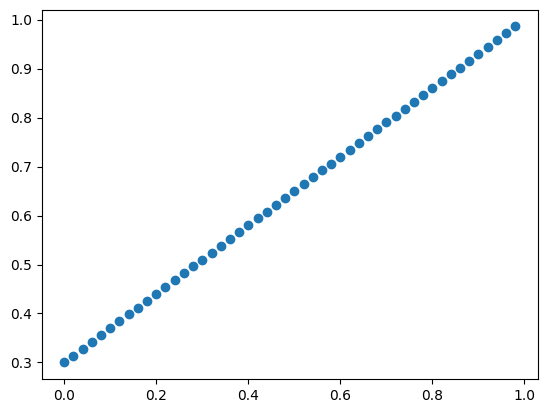

In [ ]:
#y= weight*x + c
weight=0.7
bias=0.3
X=torch.arange(0,1,0.02).unsqueeze(dim=1)
y=weight*X+bias
#Display
plt.scatter(X,y)

In [ ]:
train_split=int(0.8*len(X))
X_train,y_train=X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)
assert len(X_train)==len(y_train)
assert len(X_test)==len(y_test)
assert len(X_train)+len(X_test)==len(X)

In [ ]:
from torch.utils.data import TensorDataset,DataLoader
#wrap data as pairs of X,y
train_data=TensorDataset(X_train,y_train)
test_data=TensorDataset(X_test,y_test)
batch_size=8
num_workers=0
train_dataloader=DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_dataloader=DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
print(len(train_dataloader),len(test_dataloader),len(train_data),len(test_data))

5 2 40 10


In [ ]:
print(train_data[0])

(tensor([0.]), tensor([0.3000]))


In [ ]:
for x,y in train_dataloader:
  print(x.flatten(),y.flatten())


tensor([0.4400, 0.2800, 0.0000, 0.4000, 0.7600, 0.6400, 0.5000, 0.1000]) tensor([0.6080, 0.4960, 0.3000, 0.5800, 0.8320, 0.7480, 0.6500, 0.3700])
tensor([0.1600, 0.6200, 0.2000, 0.0800, 0.6800, 0.3000, 0.3800, 0.5200]) tensor([0.4120, 0.7340, 0.4400, 0.3560, 0.7760, 0.5100, 0.5660, 0.6640])
tensor([0.2200, 0.7200, 0.1400, 0.7400, 0.4200, 0.7000, 0.5600, 0.0200]) tensor([0.4540, 0.8040, 0.3980, 0.8180, 0.5940, 0.7900, 0.6920, 0.3140])
tensor([0.7800, 0.4800, 0.6600, 0.5400, 0.0400, 0.3600, 0.4600, 0.1200]) tensor([0.8460, 0.6360, 0.7620, 0.6780, 0.3280, 0.5520, 0.6220, 0.3840])
tensor([0.0600, 0.1800, 0.2400, 0.3200, 0.6000, 0.5800, 0.3400, 0.2600]) tensor([0.3420, 0.4260, 0.4680, 0.5240, 0.7200, 0.7060, 0.5380, 0.4820])


In [ ]:
def plot_predictions(
     train_data=X_train,
     train_labels=y_train,
     test_data=X_test,
     test_labels=y_test,
     predictions=None,):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data,train_labels,c="green",s=25,alpha=0.5,label="training data",marker='o')
  plt.scatter(test_data,test_labels,c="blue",s=25,alpha=0.7,label="testing data",marker='s')
  if predictions is not None:
    plt.scatter(test_data,predictions,c="red",s=25,alpha=0.8,label="predictions",marker='x')
  plt.legend()
  plt.xlabel("input features(X)",fontsize=12)
  plt.ylabel("target labels(y)",fontsize=12)
  plt.title("linear regression",fontsize=16,fontweight='bold')
  plt.legend(fontsize=11)
  plt.grid(True,alpha=0.3)
  plt.tight_layout()
  plt.show()


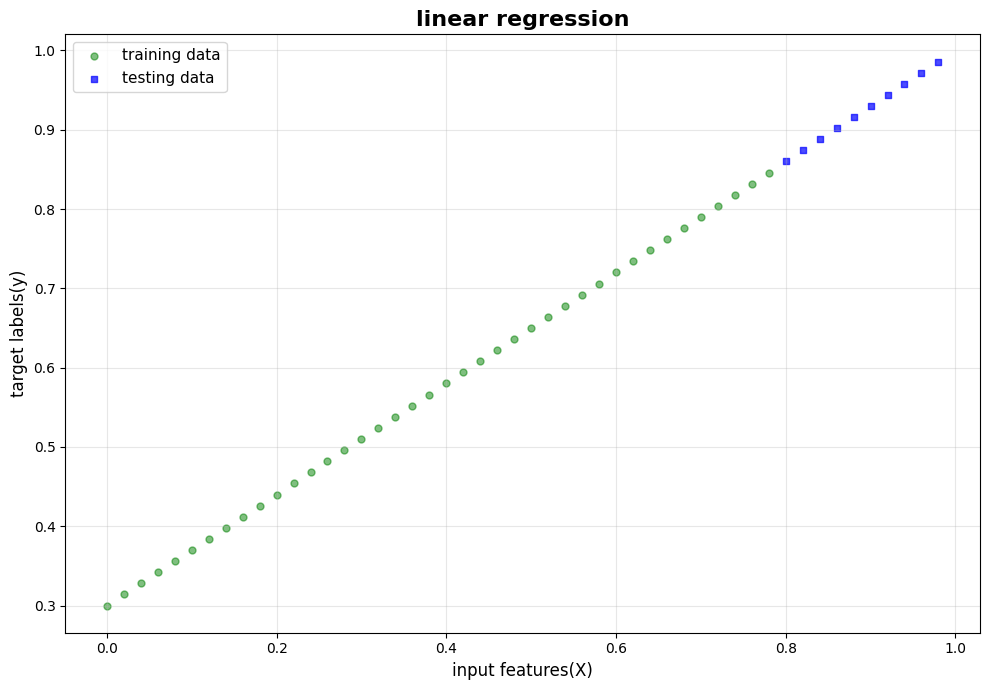

In [ ]:
plot_predictions()

In [ ]:
import torch.nn as nn

In [ ]:
"""
Linear Regression Model
y= weight*x + bias
input:one feature per sample
output:one value per sample
parameters:weight,bias
"""
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
    self.bias=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

  def forward(self,x:torch.tensor)->torch.Tensor:
    return self.weight*x+self.bias




In [ ]:
model=LinearRegressionModel()
x=torch.tensor([[2.0],[3.0],[4.0]])
y_pred=model(x)
y_pred

tensor([[-0.2560],
        [-0.1641],
        [-0.0722]], grad_fn=<AddBackward0>)

In [ ]:
from torch.nn.modules import linear
from numpy import absolute
#custom loss functions
class MeanAbsoluteError(nn.Module):
  """
  Mae=mean(abs(y_pred-y_true))
  """
  def __init__(self):
    super().__init__()
  def forward(self,predictions:torch.Tensor,targets:torch.Tensor)->torch.Tensor:
    """
    Compute mean Absolute error between predictions and target
    parameters:
    predictions: torch.tensor,shape[batch size,dim]
    targets:same
    """
    absolute_errors = torch.abs(predictions-targets)
    return torch.mean(absolute_errors)


In [ ]:
class HuberLoss(nn.Module):


    """Quadratic loss for small errors (smooth gradients)
    -linear for large errors (robust to outliers)
    L_delta(a) = 0.5*a*a if abs(a) <=delta
    L_delta(a) = delta*(abs(a)-0.5*delta) if abs(a) > delta
    """

    def __init__(self,delta=1.0):
      super().__init__()
      self.delta=delta
    def forward(self,predictions:torch.Tensor,targets:torch.Tensor)->torch.Tensor:
      residuals=predictions-targets
      abs_residuals=torch.abs(residuals)
      #apply huber loss
      quadratic_mask=abs_residuals <=self.delta
      linear_mask=abs_residuals >self.delta
      quadratic_loss=0.5*residuals**2
      linear_loss=self.delta*abs_residuals-0.5*self.delta**2
      loss=quadratic_loss*quadratic_mask+linear_loss*linear_mask
      return torch.mean(loss)




In [ ]:
custom_mae_loss=MeanAbsoluteError()
huber_loss=HuberLoss()
print("cutom loss function initialized")
print("mae loss:",custom_mae_loss)
print("huber loss:",huber_loss)
sample_predictions=torch.tensor([1.,2.,3.])
sample_targets=torch.tensor([1.1,1.8,3.2])
mae_loss=custom_mae_loss(sample_predictions,sample_targets)
huber_loss=huber_loss(sample_predictions,sample_targets)

cutom loss function initialized
mae loss: MeanAbsoluteError()
huber loss: HuberLoss()


In [ ]:
mae_loss
huber_loss
nn.L1Loss()(sample_predictions,sample_targets)

tensor(0.1667)

In [43]:
#set manual seed , nn.parameters are randomly initialized
torch.manual_seed(42)
model_0=LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [44]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [45]:
#make predictions with model
with torch.inference_mode():
  y_preds=model_0(X_test)
  y_preds

In [46]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

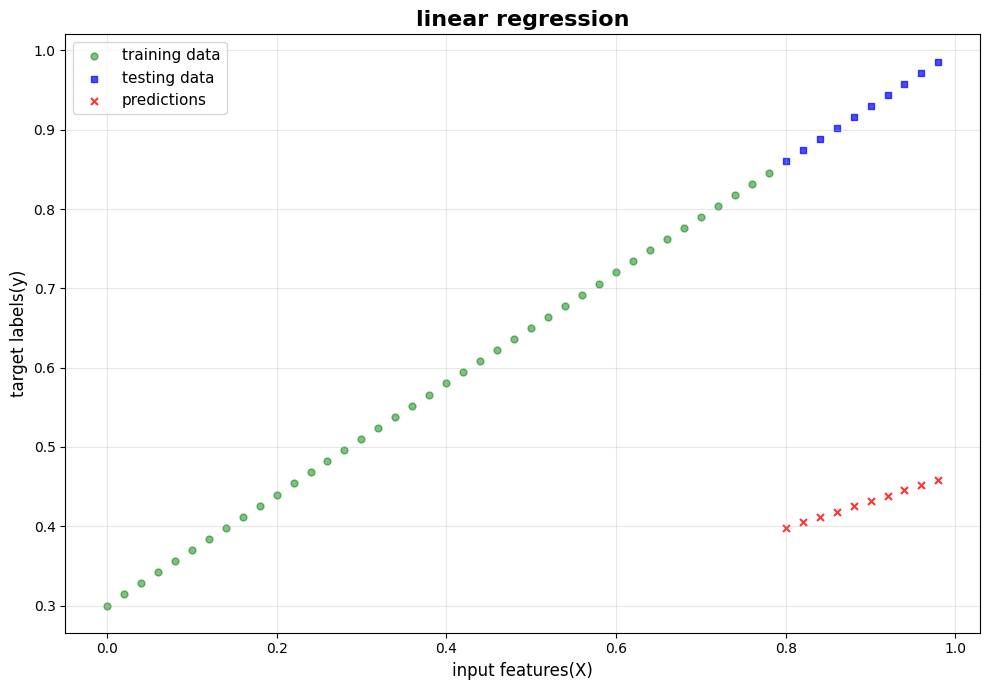

In [47]:
plot_predictions(predictions=y_preds)

In [48]:
#configure loss function
loss_fn=nn.L1Loss()
# configure the optimization algorithgn
optimizer=torch.optim.SGD(
    params=model_0.parameters() #model parameters to be updated
    ,lr=0.001 #learning rate
    )
print(optimizer)
print(optimizer.param_groups[0]['lr'])
print(len(list(model_0.parameters())))


SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
0.001
2


In [49]:
#number of epochs - number of times the model will pass over the training data
epochs=100
for epoch in range(epochs):
  model_0.train() # puts the model in training mode
  y_pred = model_0(X_train) # forward pass on training data
  loss=loss_fn(y_pred,y_train) # calculate the loss function
  optimizer.zero_grad()  #zero out the gradient
  loss.backward()  #backpropagation
  optimizer.step() #update the parameters



In [50]:
model_0.eval() # put the model in ecal mode
with torch.inference_mode():
  test_preds=model_0(X_test)
  test_loss=loss_fn(test_preds,y_test)
  if epoch%10==0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

In [51]:
torch.manual_seed(42)
EPOCHS=350
PRINT_INTERVAL=20
# initialize tracking variables for loss curves
train_loss_values=[]
test_loss_values=[]
epoch_count=[]
print("training progress")
print("="*60)
#Main training loop
for epoch in range(EPOCHS):
  model_0.train()
  epoch_train_loss=0.0
  num_train_batches=0
  for X_batch,y_batch in train_dataloader:
    y_pred=model_0(X_batch)   #prediction for a batch

    batch_loss=loss_fn(y_pred,y_batch) # loss for a batch
    optimizer.zero_grad()  #zeroing out the gradients from previous iterations
    batch_loss.backward()  #calculate gradients via automatic differentiation
    optimizer.step()
    epoch_train_loss+=batch_loss.item()
    num_train_batches+=1
  avg_train_loss=epoch_train_loss/num_train_batches
  model_0.eval() #set model in evaluation mode -disables gradient computations
  epoch_test_loss=0.0
  num_test_batches=0

  with torch.inference_mode():
    for X_batch,y_batch in test_dataloader:
      test_pred=model_0(X_batch)
      batch_test_loss=loss_fn(test_pred,y_batch)
      epoch_test_loss+=batch_test_loss.item()
      num_test_batches+=1
    avg_test_loss=epoch_test_loss/num_test_batches
  if epoch%PRINT_INTERVAL==0:
    epoch_count.append(epoch)
    train_loss_values.append(avg_train_loss)
    test_loss_values.append(avg_test_loss)
    print(f"Epoch: {epoch} | MAE Train Loss: {avg_train_loss} | MAE Test Loss: {avg_test_loss}")
print("="*60)
print("training completed")
print(avg_train_loss,avg_test_loss)



training progress
Epoch: 0 | MAE Train Loss: 0.19537073969841004 | MAE Test Loss: 0.3530910611152649
Epoch: 20 | MAE Train Loss: 0.0886523738503456 | MAE Test Loss: 0.22827255725860596
Epoch: 40 | MAE Train Loss: 0.053334273397922516 | MAE Test Loss: 0.1452169194817543
Epoch: 60 | MAE Train Loss: 0.04537384659051895 | MAE Test Loss: 0.1119367778301239
Epoch: 80 | MAE Train Loss: 0.04155058562755585 | MAE Test Loss: 0.09757868200540543
Epoch: 100 | MAE Train Loss: 0.038092248141765594 | MAE Test Loss: 0.08639537170529366
Epoch: 120 | MAE Train Loss: 0.03473333939909935 | MAE Test Loss: 0.07675173506140709
Epoch: 140 | MAE Train Loss: 0.031194745004177092 | MAE Test Loss: 0.07233909517526627
Epoch: 160 | MAE Train Loss: 0.027797619998455047 | MAE Test Loss: 0.06578449532389641
Epoch: 180 | MAE Train Loss: 0.024301879107952118 | MAE Test Loss: 0.057383403182029724
Epoch: 200 | MAE Train Loss: 0.020947425067424773 | MAE Test Loss: 0.05164904147386551
Epoch: 220 | MAE Train Loss: 0.01743452

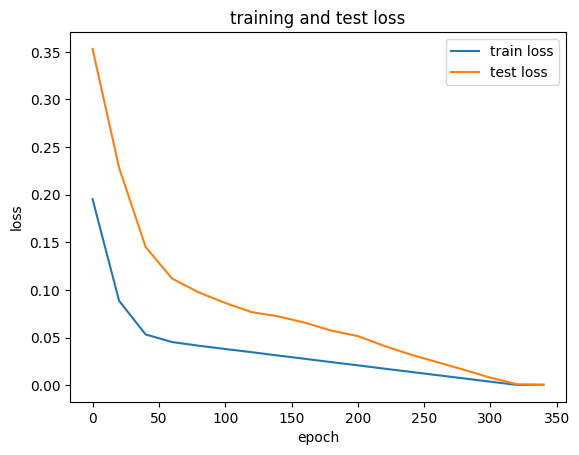

In [53]:
plt.plot(epoch_count,train_loss_values,label="train loss")
plt.plot(epoch_count,test_loss_values,label="test loss")
plt.title("training and test loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [54]:
learned_params=model_0.state_dict()
print("learned parameters")
for param_name,param_value in learned_params.items():
  print(f"{param_name}: {param_value.item():.6f}")

learned parameters
weight: 0.700619
bias: 0.300559


In [55]:
print("ground truth parameters")
print(f"weight: {weight}")
print(f"bias: {bias}")

ground truth parameters
weight: 0.7
bias: 0.3


MOdel serializatrion helps learned parameters from memory to disk file and load them back whenever required


In [59]:
from pathlib import Path
MODEL_PATH =Path("models") #path object pointing to ./models
MODEL_PATH.mkdir(parents=True,exist_ok=True) #creates folder
MODEL_NAME="linear_regression_model.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME
print(MODEL_SAVE_PATH)

#saving the model weights
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)

if MODEL_SAVE_PATH.exists():
  file_size=MODEL_SAVE_PATH.stat().st_size
  print(file_size)
  print(len(model_0.state_dict()))
else:
  print("model save path does not exist")

# load the model back and examine

saved_state=torch.load(MODEL_SAVE_PATH,weights_only=True)

for param_name , param_value in saved_state.items():
  print(f"{param_name}: {param_value.item():.6f}")


models/linear_regression_model.pth
2085
2
weight: 0.700619
bias: 0.300559
